In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
import datetime
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import geopy.distance
%matplotlib inline
pd.set_option('display.max_rows', 500)

/home/marcel/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
con = sqlalchemy.create_engine("sqlite:///mta_data.db")

### Working with MTA Data

In [3]:
#Using Code from MTA Exercises
mta_data = pd.read_sql_query("SELECT * FROM mta_data", con)
#set datetime
mta_data["DATE_TIME"] = pd.to_datetime(mta_data.DATE + " " + mta_data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
#Remove duplicates
mta_data.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
mta_data.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [4]:
#Using Code from MTA Exercises
# Clean data for turnstile data
turnstiles_daily = (mta_data
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily1 = (mta_data
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.first())
turnstiles_daily["EXITS"] = turnstiles_daily1["EXITS"]

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

turnstiles_daily[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

def get_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def get_daily_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
# If counter is > 100,000, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_entries, axis=1, max_counter=100000)
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_daily_exits, axis=1, max_counter=100000)

/tmp/ipykernel_602/2583428940.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
/tmp/ipykernel_602/2583428940.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily


### Daily Entries and Exits

In [5]:
#Using some Code from MTA Exercises
# Get station daily entries and exits and day of week for each day
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily1 = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
station_daily["DAILY_EXITS"] = station_daily1["DAILY_EXITS"]
station_daily['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek

### Day of Week Totals and Totals

In [6]:
# Get dfs for station by Day of Week, Total exits for the 3 months and total entries for the 3 months
station_by_DOW = station_daily.groupby(["STATION", "DAY_OF_WEEK_NUM"])[["DAILY_EXITS"]].sum().reset_index()
station_DOW_entries = station_daily.groupby(["STATION", "DAY_OF_WEEK_NUM"])[["DAILY_ENTRIES"]].sum().reset_index()
station_by_DOW["DAILY_ENTRIES"] = station_DOW_entries["DAILY_ENTRIES"]
station_totals = station_daily.groupby(["STATION"])[["DAILY_EXITS"]].sum().reset_index()
station_total_entries = station_daily.groupby(["STATION"])[["DAILY_ENTRIES"]].sum().reset_index()
station_totals["DAILY_ENTRIES"] = station_total_entries["DAILY_ENTRIES"]
weekday_totals = station_by_DOW[station_by_DOW["DAY_OF_WEEK_NUM"] <5].groupby(["STATION"])[["DAILY_EXITS"]].sum().reset_index()

### Geolocation Data Cleaning

In [7]:
#Struggled to find a way to make the station location data match
#Followed a guide using Fuzzywuzzy to make the best estimates https://towardsdatascience.com/visualizing-nycs-subway-traffic-census-data-using-leafmap-29904b634046
station_data = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/Stations.csv")
station_data = station_data[["Stop Name", "GTFS Latitude", "GTFS Longitude"]]
station_data = station_data.rename(columns = {"Stop Name":"stop_name"})
#Cleaning strings for fuzzy wuzzy use
station_data.stop_name = station_data.stop_name.str.replace(" - ","_")
station_data.stop_name = station_data.stop_name.str.replace("(","")
station_data.stop_name = station_data.stop_name.str.replace(")","")
station_data.stop_name = station_data.stop_name.str.replace("/","_")
station_data.stop_name = station_data.stop_name.str.replace(".","")
station_data.stop_name = station_data.stop_name.str.upper()

list1 = station_data['stop_name'].tolist()
list2 = station_daily['STATION'].unique().tolist()
mat1 = []
mat2 = []
p= []

threshold = 70

for i in list1:
    mat1.append(process.extractOne(i, list2, scorer=fuzz.ratio))

station_data['matches'] = mat1

for j in station_data['matches']:
    if j[1] >= threshold:
        p.append(j[0])
            
    mat2.append(','.join(p))
    p= []
    
station_data['matches'] = mat2

/tmp/ipykernel_602/937632753.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  station_data.stop_name = station_data.stop_name.str.replace("(","")
/tmp/ipykernel_602/937632753.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  station_data.stop_name = station_data.stop_name.str.replace(")","")
/tmp/ipykernel_602/937632753.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  station_data.stop_name = station_data.stop_name.str.replace(".","")


In [8]:
#Merge the results from above with the dfs we want to work with
station_daily_geo = station_daily.merge(station_data[["matches", "GTFS Latitude","GTFS Longitude"]], how = "left", left_on = "STATION", right_on = "matches")
weekday_totals_geo = weekday_totals.merge(station_data[["matches", "GTFS Latitude","GTFS Longitude"]], how = "left", left_on = "STATION", right_on = "matches")
station_totals_geo = station_totals.merge(station_data[["matches", "GTFS Latitude","GTFS Longitude"]], how = "left", left_on = "STATION", right_on = "matches")

In [9]:
station_daily_geo = station_daily_geo.drop(["matches"], axis = 1)
weekday_totals_geo = weekday_totals_geo.drop(["matches"], axis = 1)
station_totals_geo = station_totals_geo.drop(["matches"], axis = 1)

In [10]:
station_daily_gdf = gpd.GeoDataFrame(station_daily_geo, geometry=gpd.points_from_xy(station_daily_geo["GTFS Longitude"],station_daily_geo["GTFS Latitude"]))
weekday_totals_gdf = gpd.GeoDataFrame(weekday_totals_geo, geometry=gpd.points_from_xy(weekday_totals_geo["GTFS Longitude"],weekday_totals_geo["GTFS Latitude"]))
station_totals_gdf = gpd.GeoDataFrame(station_totals_geo, geometry=gpd.points_from_xy(station_totals_geo["GTFS Longitude"],station_totals_geo["GTFS Latitude"]))
station_totals_gdf.set_crs(4326, inplace=True)
weekday_totals_gdf.set_crs(4326, inplace=True)
station_daily_gdf.set_crs(4326, inplace=True)

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAY_OF_WEEK_NUM,GTFS Latitude,GTFS Longitude,geometry
0,1 AV,04/28/2019,5205.0,7239.0,6,40.730953,-73.981628,POINT (-73.98163 40.73095)
1,1 AV,04/29/2019,17134.0,19320.0,0,40.730953,-73.981628,POINT (-73.98163 40.73095)
2,1 AV,04/30/2019,18588.0,20421.0,1,40.730953,-73.981628,POINT (-73.98163 40.73095)
3,1 AV,05/01/2019,19221.0,21124.0,2,40.730953,-73.981628,POINT (-73.98163 40.73095)
4,1 AV,05/02/2019,19406.0,21335.0,3,40.730953,-73.981628,POINT (-73.98163 40.73095)
...,...,...,...,...,...,...,...,...
45480,ZEREGA AV,07/22/2019,2478.0,2324.0,0,40.836488,-73.847036,POINT (-73.84704 40.83649)
45481,ZEREGA AV,07/23/2019,2520.0,2374.0,1,40.836488,-73.847036,POINT (-73.84704 40.83649)
45482,ZEREGA AV,07/24/2019,2619.0,2491.0,2,40.836488,-73.847036,POINT (-73.84704 40.83649)
45483,ZEREGA AV,07/25/2019,2627.0,2448.0,3,40.836488,-73.847036,POINT (-73.84704 40.83649)


In [11]:
#Base NY map for plotting
ny_map = gpd.read_file("nybb_22a/nybb.shp")
ny_map.to_crs(4326, inplace=True)
ny_map['coords'] = ny_map['geometry'].apply(lambda x: x.representative_point().coords[:])
ny_map['coords'] = [coords[0] for coords in ny_map['coords']]

### Working with Starbucks Data

In [12]:
sbux = pd.read_csv("starbucks_us_locations.csv", header = None)
sbux = sbux.rename(columns = {0:"Long", 1:"Lat", 2:"State", 3:"address"})
sbux["State"] = sbux.State.str.split("-")
sbux["State"] = sbux['State'].str[1]
sbux["State"] = sbux.State.str.strip()
ny_sbux = sbux[(sbux["State"] == 'NY')]
ny_sbux = ny_sbux.reset_index(drop = True)

In [13]:
ny_sbux_gdf = gpd.GeoDataFrame(ny_sbux, geometry=gpd.points_from_xy(ny_sbux["Long"], ny_sbux["Lat"]))
ny_sbux_gdf.set_crs(4326, inplace=True)
#Bounding the starbucks to NYC coordinates as best I can
nyc_sbux_gdf = ny_sbux_gdf[(ny_sbux_gdf["Long"] < ny_map.total_bounds[2])
                                & (ny_sbux_gdf["Long"] > ny_map.total_bounds[0])
                                & (ny_sbux_gdf["Lat"] > ny_map.total_bounds[1]) 
                                & (ny_sbux_gdf["Lat"] < ny_map.total_bounds[3])]
nyc_sbux_gdf= nyc_sbux_gdf.reset_index(drop = True)

### Find closest starbucks to each train station for Totals and weekday totals

In [14]:
station_totals_gdf = station_totals_gdf.dropna()
station_totals_gdf = station_totals_gdf.reset_index(drop = True)
weekday_totals_gdf = weekday_totals_gdf.dropna()
weekday_totals_gdf = weekday_totals_gdf.reset_index(drop = True)

In [15]:
station_totals_gdf["DISTANCE"] = ""
for i in range(0,len(station_totals_gdf)):
    station_totals_gdf["DISTANCE"].at[i] = geopy.distance.geodesic((station_totals_gdf["GTFS Latitude"].iloc[i],station_totals_gdf["GTFS Longitude"].iloc[i]),
                            (nyc_sbux_gdf["Lat"].iloc[0],nyc_sbux_gdf["Long"].iloc[0])).meters
    for j in range(1, len(nyc_sbux_gdf)):
        b = geopy.distance.geodesic((station_totals_gdf["GTFS Latitude"].iloc[i],station_totals_gdf["GTFS Longitude"].iloc[i]),
                            (nyc_sbux_gdf["Lat"].iloc[j],nyc_sbux_gdf["Long"].iloc[j])).meters
        if(b < station_totals_gdf["DISTANCE"].at[i]):
            station_totals_gdf["DISTANCE"].at[i] = b
            
    

In [16]:
weekday_totals_gdf["DISTANCE"] = ""
for i in range(0,len(weekday_totals_gdf)):
    weekday_totals_gdf["DISTANCE"].at[i] = geopy.distance.geodesic((weekday_totals_gdf["GTFS Latitude"].iloc[i],weekday_totals_gdf["GTFS Longitude"].iloc[i]),
                            (nyc_sbux_gdf["Lat"].iloc[0],nyc_sbux_gdf["Long"].iloc[0])).meters
    for j in range(1, len(nyc_sbux_gdf)):
        b = geopy.distance.geodesic((weekday_totals_gdf["GTFS Latitude"].iloc[i],weekday_totals_gdf["GTFS Longitude"].iloc[i]),
                            (nyc_sbux_gdf["Lat"].iloc[j],nyc_sbux_gdf["Long"].iloc[j])).meters
        if(b < weekday_totals_gdf["DISTANCE"].at[i]):
            weekday_totals_gdf["DISTANCE"].at[i] = b

### Plots

Text(0.5, 1.0, 'Stations (sized by ridership) and Starbucks (orange) map')

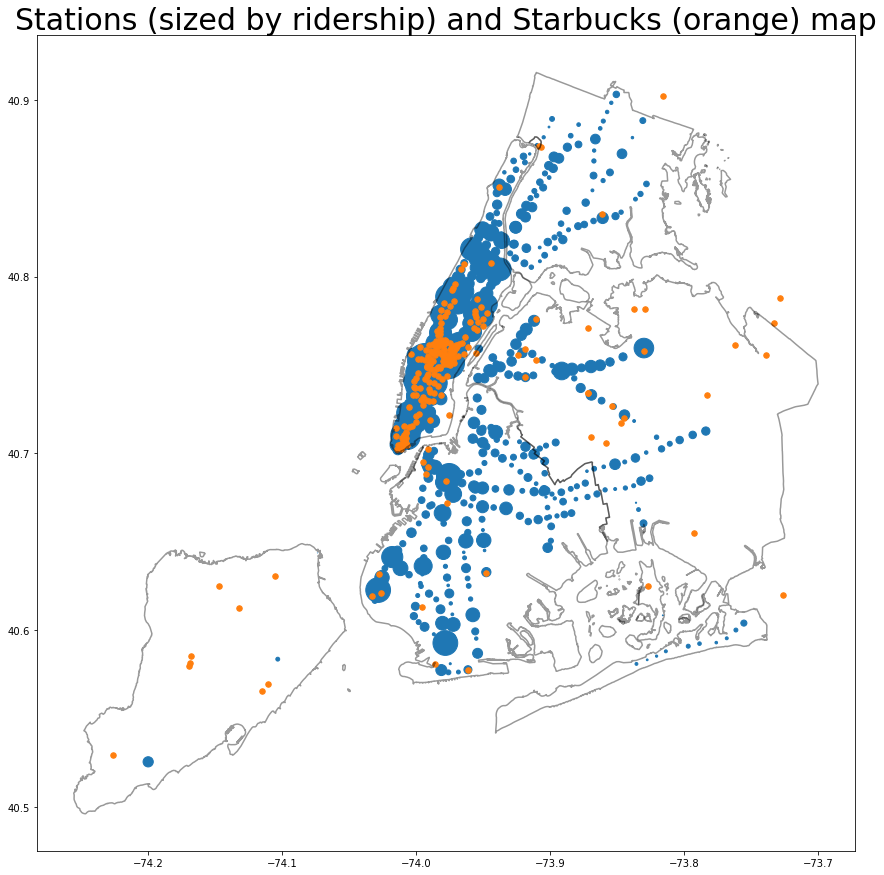

In [17]:
base = ny_map.boundary.plot( edgecolor='k', alpha = 0.4, figsize=(15,15))
station_totals_gdf.plot(ax=base, markersize = station_totals_gdf["DAILY_EXITS"]/10000)
nyc_sbux_gdf.plot(ax=base, markersize = 30)
base.set_title("Stations (sized by ridership) and Starbucks (orange) map", fontsize = 30)

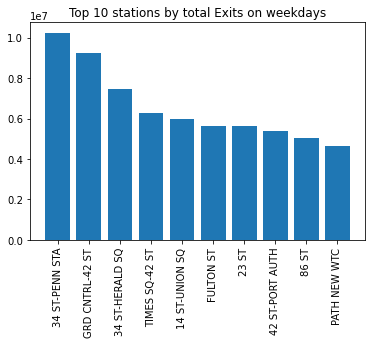

In [18]:
x= weekday_totals.sort_values("DAILY_EXITS", ascending = False)[0:10]
x = x.reset_index(drop = True)
plt.bar(x["STATION"], height = x["DAILY_EXITS"])
plt.xticks(rotation = 90)
plt.title("Top 10 stations by total Exits on weekdays")
plt.show()

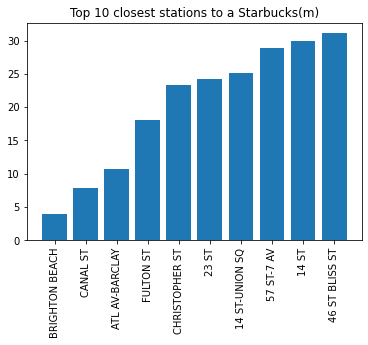

In [19]:
x = station_totals_gdf.sort_values("DISTANCE", ascending = True)[0:10]
x = x.reset_index(drop = True)
plt.bar(x["STATION"], height = x["DISTANCE"])
plt.xticks(rotation = 90)
plt.title("Top 10 closest stations to a Starbucks(m)")
plt.show()

Text(627.9800000000001, 0.5, 'Distance from Starbucks (m)')

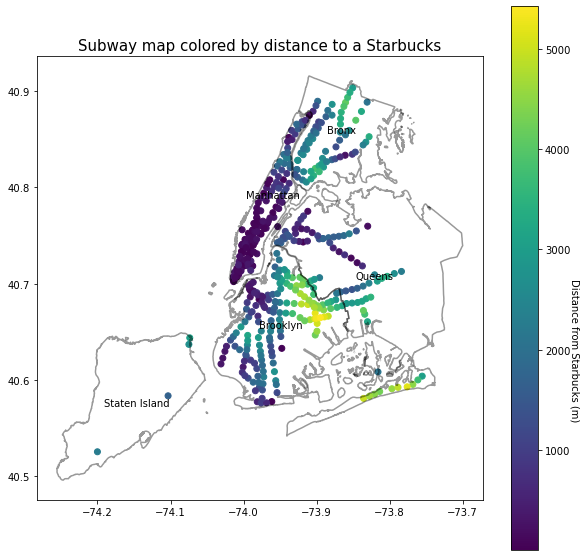

In [20]:
station_totals_gdf["DISTANCE"] = pd.to_numeric(station_totals_gdf["DISTANCE"])
x = station_totals_gdf.sort_values("DAILY_EXITS", ascending = False)
x = x.reset_index(drop = True)
base = ny_map.boundary.plot( edgecolor='k', alpha = 0.4, figsize=(10,10))
base.set_title("Subway map colored by distance to a Starbucks", fontsize = 15)
for idx, row in ny_map.iterrows():
    base.annotate(text = row['BoroName'], xy=row['coords'], horizontalalignment='center')
x.plot(ax=base, column = "DISTANCE", legend = True)
base.figure.axes[1].set_ylabel('Distance from Starbucks (m)', fontsize = 10, rotation=-90, rotation_mode = 'default')


<AxesSubplot:title={'center':'Subway stations furthest from a starbucks'}>

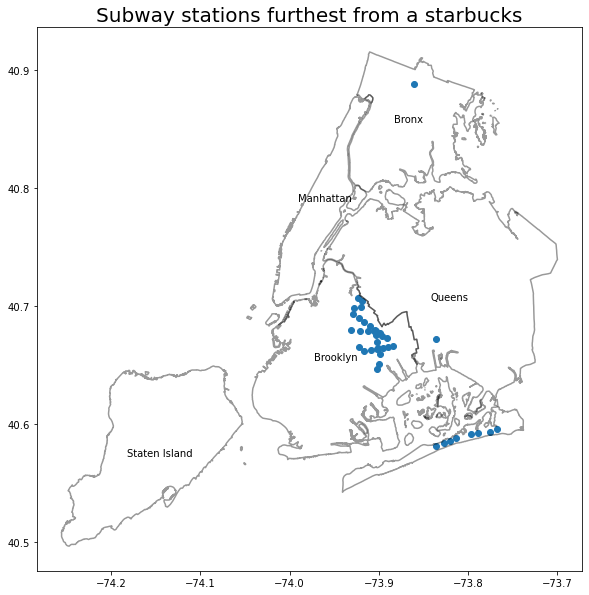

In [22]:
x = weekday_totals_gdf.sort_values("DISTANCE", ascending = False)[0:40]
x = x.reset_index(drop = True)
base = ny_map.boundary.plot( edgecolor='k', alpha = 0.4, figsize=(10,10))
for idx, row in ny_map.iterrows():
    base.annotate(text = row['BoroName'], xy=row['coords'], horizontalalignment='center')
base.set_title("Subway stations furthest from a starbucks", fontsize = 20)
x.plot(ax=base)

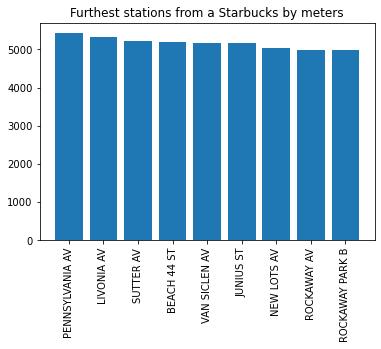

In [23]:
x = station_totals_gdf.sort_values("DISTANCE", ascending = False)[0:10]
x = x.reset_index(drop = True)
plt.bar(x["STATION"], height = x["DISTANCE"])
plt.xticks(rotation = 90)
plt.title("Furthest stations from a Starbucks by meters")
plt.show()

Text(640.7300000000001, 0.5, 'Traffic')

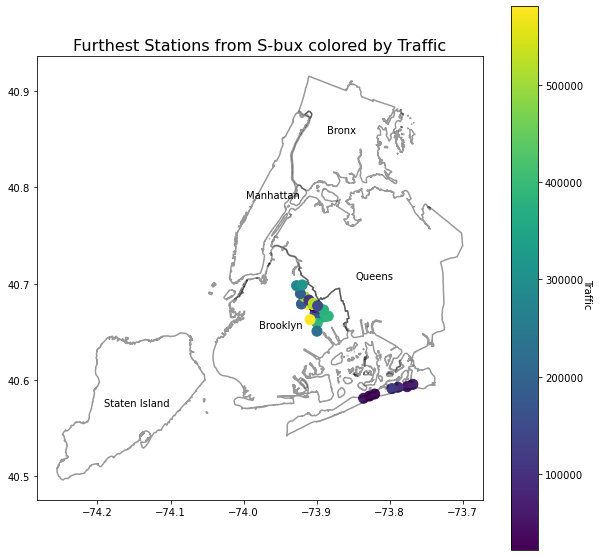

In [24]:
weekday_totals_gdf["DISTANCE"] = pd.to_numeric(weekday_totals_gdf["DISTANCE"])
x = weekday_totals_gdf.sort_values("DISTANCE", ascending = False)[0:30]
x = x.reset_index(drop = True)
base = ny_map.boundary.plot( edgecolor='k', alpha = 0.4, figsize=(10,10))
base.set_title("Furthest Stations from S-bux colored by Traffic", fontsize = 16)
for idx, row in ny_map.iterrows():
    base.annotate(text = row['BoroName'], xy=row['coords'], horizontalalignment='center')
x.plot(ax=base, column= "DAILY_EXITS", markersize = 100, legend = True)
base.figure.axes[1].set_ylabel('Traffic', fontsize = 10, rotation=-90, rotation_mode = 'default')

Text(627.9800000000001, 0.5, 'Distance from Starbucks (m)')

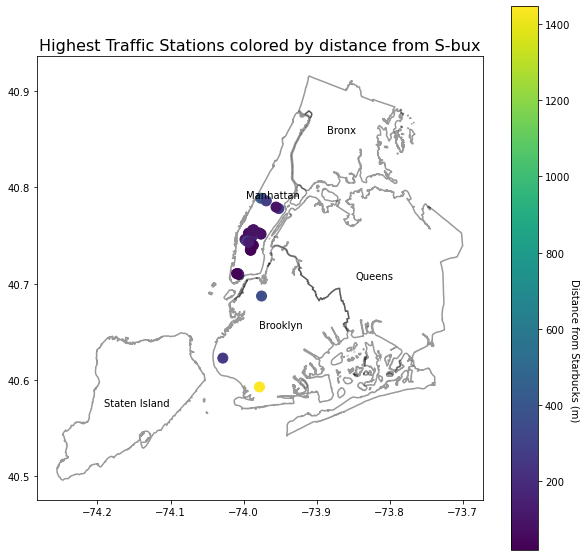

In [25]:
weekday_totals_gdf["DISTANCE"] = pd.to_numeric(weekday_totals_gdf["DISTANCE"])
x = weekday_totals_gdf.sort_values("DAILY_EXITS", ascending = False)[0:30]
x = x.reset_index(drop = True)
base = ny_map.boundary.plot( edgecolor='k', alpha = 0.4, figsize=(10,10))
base.set_title("Highest Traffic Stations colored by distance from S-bux", fontsize = 16)
for idx, row in ny_map.iterrows():
    base.annotate(text = row['BoroName'], xy=row['coords'], horizontalalignment='center')
x.plot(ax=base, column= "DISTANCE", markersize = 100, legend = True)
base.figure.axes[1].set_ylabel('Distance from Starbucks (m)', fontsize = 10, rotation=-90, rotation_mode = 'default')

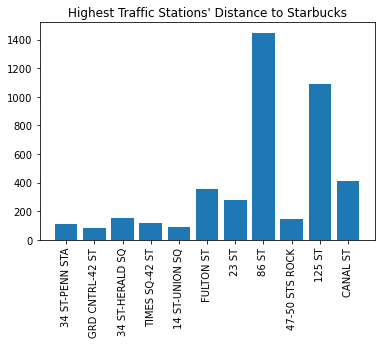

In [26]:
# Not good data because of the fuzzy merge
x= weekday_totals_gdf.sort_values("DAILY_EXITS", ascending = False)[0:40]
x = x.reset_index(drop = True)
plt.bar(x["STATION"], height = x["DISTANCE"])
plt.xticks(rotation = 90)
plt.title("Highest Traffic Stations' Distance to Starbucks")
plt.show()